In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import warnings
warnings.filterwarnings('ignore')

In [233]:
import pandas as pd
import scipy.io
import matplotlib.pyplot as plt
import math
import numpy as np
from scipy.optimize import minimize

## Machine Learning: Programming Exercise 5
## Regularized Linear Regression and Bias vs. Variance
In this exercise, you will implement regularized linear regression and use it to study models with different bias-variance properties.
## 1. Regularized Linear Regression
### 1.1 Visualizing the dataset
1. A training set that your model will learn on: X, y
2. A cross validation set for determining the regularization parameter: Xval, yval
3. A test set for evaluating performance. These are 'unseen' examples which your model did not see during training: Xtest, ytest

In [105]:
mat = scipy.io.loadmat('ex5data1.mat')
X = mat['X']
y = mat['y']
Xval = mat['Xval']
yval = mat['yval']
Xtest = mat['Xtest']
ytest = mat['ytest']

In [106]:
X.shape

(12, 1)

<Figure size 432x360 with 0 Axes>

Text(0.5, 0, 'Change in water level (x)')

Text(0, 0.5, 'Water flowing out of the dam (y)')

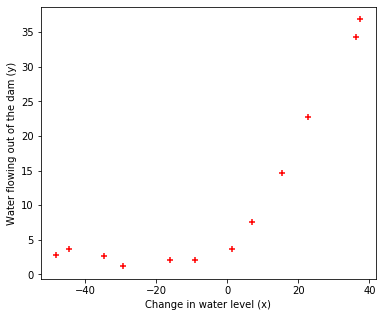

In [107]:
plt.figure(figsize=(6,5))
plt.scatter(x = X, y =y, marker='+', c='red')
plt.xlabel('Change in water level (x)')
plt.ylabel('Water flowing out of the dam (y)')

### 1.2 Regularized linear regression cost function

In [120]:
def linearRegCostFunction(theta, X, y, reg):
    m = X.shape[0]
    h_theta = np.dot(X, theta)
    J = 1/(2*m) * np.dot((h_theta-y).T, h_theta-y) + (reg/(2*m)) * np.dot(theta[1:].T, theta[1:])
    return J

def linearGradient(theta, X, y, reg):
    m = X.shape[0]
    h_theta = np.dot(X, theta)
    temp = theta.copy()
    temp[0] = 0
    grad = (1 / m) * np.dot(X.T, (h_theta - y)) + reg / m * temp
    return grad

In [121]:
theta = np.ones((2,1))
m = X.shape[0]
J = linearRegCostFunction(theta, np.concatenate((np.ones((m,1)), X), axis=1), y, 1)
print('Cost at theta = [1 ; 1]: ', J)

Cost at theta = [1 ; 1]:  [[303.99319222]]


### 1.3 Regularized linear regression gradient

In [122]:
grad = linearGradient(theta, np.concatenate((np.ones((m,1)), X), axis=1), y, 1)
print('Gradient at theta = [1 ; 1]:  ',grad)

Gradient at theta = [1 ; 1]:   [[-15.30301567]
 [598.25074417]]


### 1.4 Fitting linear regression

In [239]:
def trainLinearReg(X, y, reg):
    # Initialize Theta
    initial_theta = np.zeros((X.shape[1], 1))
    # Minimize using fmin_tnc
#     opt_weights = fmin_cg(linearRegCostFunction, x0=initial_theta, 
#                            fprime=linearGradient, args=(X, y.flatten(), reg))
    opt_weights = minimize(fun = linearRegCostFunction, x0 = initial_theta, 
                            args = (X, y.flatten(), reg),method = 'TNC', jac = linearGradient)
    return opt_weights.x

In [240]:
reg = 0
theta = trainLinearReg(np.concatenate((np.ones((m,1)), X), axis=1), y, reg)

<Figure size 432x360 with 0 Axes>

Text(0.5, 0, 'Change in water level (x)')

Text(0, 0.5, 'Water flowing out of the dam (y)')

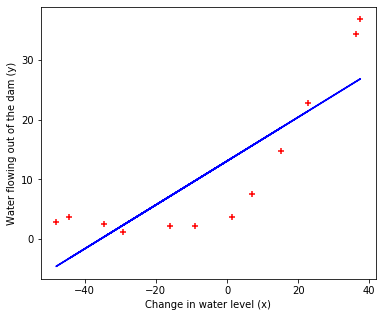

In [241]:
plt.figure(figsize=(6,5))
plt.scatter(x = X, y =y, marker='+', c='red')
plt.plot(X, np.dot(np.concatenate((np.ones((m,1)), X), axis=1), theta), c='blue')
plt.xlabel('Change in water level (x)')
plt.ylabel('Water flowing out of the dam (y)')

## 2. Bias-variance
### 2.1 Learning curves

In [253]:
def learningCurve(X, y, Xval, yval, reg):
    m = X.shape[0]
    error_train = []
    error_val = []
    for i in range(m):
        sub_X = X[:i+1]
        sub_y = y[:i+1]
        theta = trainLinearReg(sub_X, sub_y, reg)
        theta = theta.reshape(X.shape[1], 1)
        error_train.append(linearRegCostFunction(theta, sub_X, sub_y, 0)[0,0])
        error_val.append(linearRegCostFunction(theta, Xval, yval, 0)[0,0])
    return error_train, error_val

In [243]:
reg = 0
m = X.shape[0]
n = Xval.shape[0]
error_train, error_val = learningCurve(np.concatenate((np.ones((m,1)), X), axis=1), y, 
                                    np.concatenate((np.ones((n,1)), Xval), axis=1), yval, reg)

<Figure size 432x360 with 0 Axes>

Text(0.5, 0, 'Number of training examples')

Text(0, 0.5, 'Error')

Text(0.5, 1.0, 'Learning curve for linear regression')

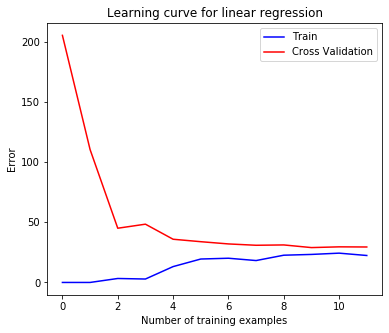

In [244]:
plt.figure(figsize=(6,5))
plt.plot(range(m), error_train, c='blue', label='Train')
plt.plot(range(m), error_val, c='red', label='Cross Validation')
plt.xlabel('Number of training examples')
plt.ylabel('Error')
plt.title('Learning curve for linear regression')
plt.legend()

## 3. Polynomial regression
the function maps the original training set $X$ of size $m*1$ into its higher powers. Specifically, when a training set $X$ of size $m*1$ is passed into the function, the function should return a $m*p$ matrix $X_{poly}$, where column 1 holds the original values of $X$, column 2 holds the values of $X^2$, column 3 holds the values of $X^3$, and so on.

In [245]:
def polyFeatures(X, p):
    m = X.shape[0]
    X_poly = np.zeros((m, p))
    for i in range(p):
        X_poly[:, i] = (X**(i+1)).flatten()
    return X_poly

def featureNormalize(X):
    mu = np.mean(X, axis=0)
    X = X-mu
    sigma = np.std(X, axis=0, ddof=1)
    X_trans = X/sigma
    return X_trans, mu, sigma

In [246]:
p = 8

# Map X onto Polynomial Features and Normalize
X_poly = polyFeatures(X, p) 
X_poly, mu, sigma = featureNormalize(X_poly)   # Normalize
X_poly = np.concatenate((np.ones((m,1)), X_poly), axis=1)    # Add Ones

# # Map X_poly_test and normalize (using mu and sigma)
X_poly_test = polyFeatures(Xtest, p) 
X_poly_test = X_poly_test-mu  # uses implicit expansion instead of bsxfun
X_poly_test = X_poly_test/sigma  # uses implicit expansion instead of bsxfun
X_poly_test = np.concatenate((np.ones((X_poly_test.shape[0],1)), X_poly_test), axis=1)  # Add Ones

# Map X_poly_val and normalize (using mu and sigma)
X_poly_val = polyFeatures(Xval, p) 
X_poly_val = X_poly_val-mu  # uses implicit expansion instead of bsxfun
X_poly_val = X_poly_val/sigma  # uses implicit expansion instead of bsxfun
X_poly_val = np.concatenate((np.ones((X_poly_val.shape[0],1)), X_poly_val), axis=1)  # Add Ones

print('Normalized Training Example 1: ', X_poly[0,:]) 

Normalized Training Example 1:  [ 1.         -0.36214078 -0.75508669  0.18222588 -0.70618991  0.30661792
 -0.59087767  0.3445158  -0.50848117]


In [247]:
reg = 0
theta = trainLinearReg(X_poly, y, reg)

In [248]:
theta

array([ 11.22056109,  10.64491797,  20.94875183,  19.01939376,
       -40.85269808, -46.26854892,  37.1359107 ,  36.85071514,
        -3.18640552])

<Figure size 432x360 with 0 Axes>

Text(0.5, 0, 'Change in water level (x)')

Text(0, 0.5, 'Water flowing out of the dam (y)')

Text(0.5, 1.0, 'Polynomial Regression Fit')

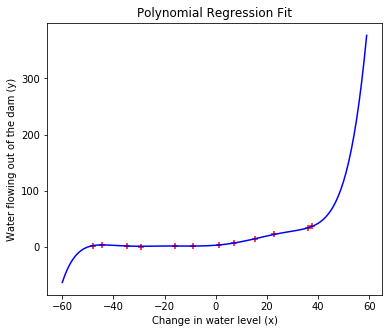

In [255]:
# create consecutive x values to plot polynomial fit
x_values = np.array(range(-60, 60)).reshape(120, 1)
x_values_poly = polyFeatures(x_values, p) 
x_values_poly = x_values_poly-mu
x_values_poly = x_values_poly/sigma  
x_values_poly = np.concatenate((np.ones((120,1)), x_values_poly), axis=1) 

plt.figure(figsize=(6,5))
plt.scatter(x = X, y =y, marker='+', c='red')
plt.plot(x_values, np.dot(x_values_poly, theta), c='blue')
plt.xlabel('Change in water level (x)')
plt.ylabel('Water flowing out of the dam (y)')
plt.title('Polynomial Regression Fit')

In [254]:
error_train, error_val = learningCurve(X_poly, y, X_poly_val, yval, reg)

<Figure size 432x360 with 0 Axes>

Text(0.5, 0, 'Number of training examples')

Text(0, 0.5, 'Error')

Text(0.5, 1.0, 'Polynomial Regression Learning Curve')

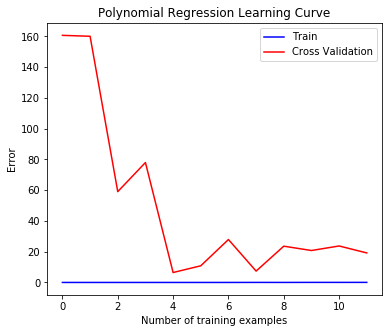

In [256]:
plt.figure(figsize=(6,5))
plt.plot(range(m), error_train, c='blue', label='Train')
plt.plot(range(m), error_val, c='red', label='Cross Validation')
plt.xlabel('Number of training examples')
plt.ylabel('Error')
plt.title('Polynomial Regression Learning Curve')
plt.legend()

In [257]:
85/(890+85)

0.08717948717948718